## Natural Language Processing (NLP)

In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter


# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV



# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')



[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
# For dataset loading
from sklearn.datasets import fetch_20newsgroups


# Set random seed for reproducibility
np.random.seed(42)


# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)


# Create a DataFrame for easier manipulation
df = pd.DataFrame({
   'text': newsgroups.data,
   'category': [newsgroups.target_names[target] for target in newsgroups.target]
})


# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


In [3]:
df.head()

,text,category
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc


In [4]:
# Get length of text column to see how big it is
df['text_len'] = df['text'].apply(len)

Text length statistics by category:
                   text_len                                                   \
                      count         mean          std    min     25%     50%   
category                                                                       
comp.graphics         584.0  1557.083904  4684.767252  125.0   572.5   883.0   
rec.autos             594.0  1444.897306  1594.224770  131.0   754.0  1133.5   
sci.space             593.0  2016.170320  3213.495426  166.0   796.0  1195.0   
talk.politics.misc    465.0  2852.027957  5105.607017  160.0  1079.0  1644.0   

                                     
                       75%      max  
category                             
comp.graphics       1341.5  60713.0  
rec.autos           1750.5  27760.0  
sci.space           1912.0  40353.0  
talk.politics.misc  2680.0  49447.0  


/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

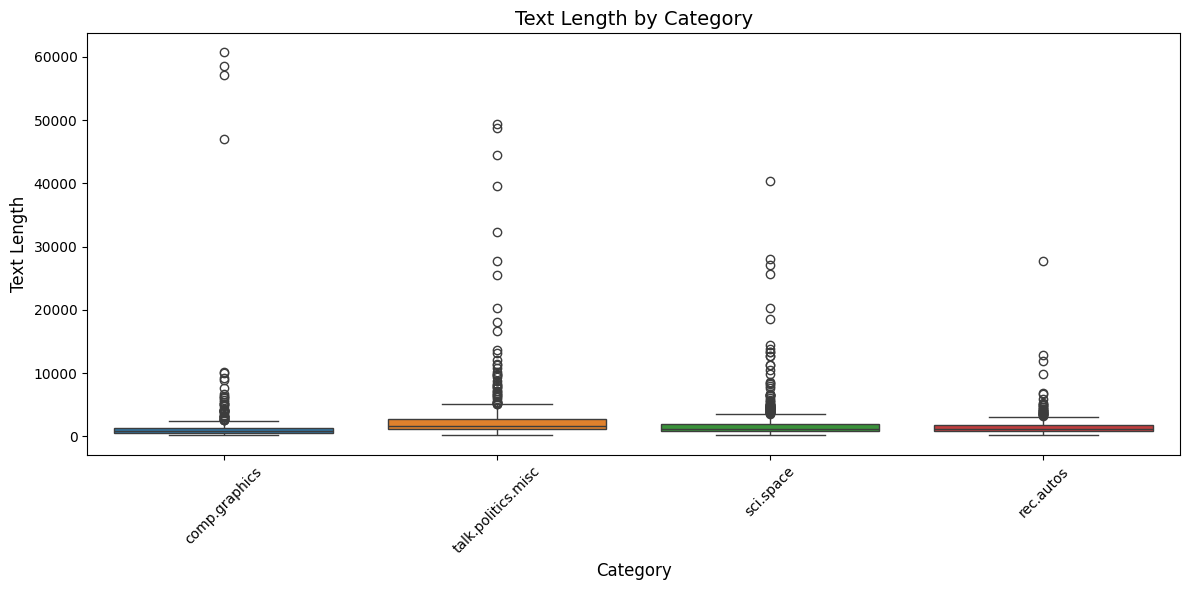

In [5]:
#Show stat description by category of len
text_length_stats = df.groupby('category').describe()

print("Text length statistics by category:")
print(text_length_stats)


#Display box plot.  You can see lots of outliers for high text length
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='text_len', data=df, hue='category', legend=False)
plt.title('Text Length by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
# Function to clean the text - lowercase, remove punctuation and numbers, and HTML

def clean_text(text):
    #Lowercase
    text = text.lower()

    #Remove HTML
    text = re.sub(r'<.*?>', '', text)

    #Remove punctuationa nd numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)


    
    return text

In [62]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def tokenize_and_lemmatize(text):
    # Llemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #Get stopwords
    stop_words = set(stopwords.words('english'))
    
    #Tokenize
    tokens = nltk.word_tokenize(text)
    
    #Tag tokens with parts of speech
    tokens_tagged = nltk.pos_tag(tokens)
    
    #Convert to WordNet POS tags
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    #Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token[0], token[1]) for token in pos_tokens if token[0] not in stop_words and len(token[0]) > 1]
    
    return processed_tokens

In [63]:
def preprocess_text(text):
    # Clean text
    cleaned_text = clean_text(text)
    
    # Lemmatization and stopwords
    processed_tokens = tokenize_and_lemmatize(cleaned_text)
    
    # Put back as complete string
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

In [64]:
#Example to view text,  Slot three only had 190 words
sample_text = df['text'].iloc[3]
print(f"Original text:\n{sample_text}")

cleaned_text = clean_text(sample_text)
print(f"\nCleaned text:\n{cleaned_text}")

tokens = tokenize_and_lemmatize(cleaned_text)
print(f"\nTokenized and lemmatized text:\n{tokens}")

processed_text = preprocess_text(sample_text)
print(f"\nFully preprocessed text:\n{processed_text}")

Original text:
From: marshatt@feserve.cc.purdue.edu (Zauberer)
Subject: Re: WARNING.....(please read)...
Organization: Purdue University
 
 Can we please stick to AUTOMOTIVE topics . Thank you.
Lines: 1




Cleaned text:
from marshattfeserveccpurdueedu zauberer
subject re warningplease read
organization purdue university
 
 can we please stick to automotive topics  thank you
lines 




Tokenized and lemmatized text:
['marshattfeserveccpurdueedu', 'zauberer', 'subject', 'warningplease', 'read', 'organization', 'purdue', 'university', 'please', 'stick', 'automotive', 'topic', 'thank', 'line']

Fully preprocessed text:
marshattfeserveccpurdueedu zauberer subject warningplease read organization purdue university please stick automotive topic thank line


In [65]:
df.head()

,text,category,text_len,cleaned_text,Lemmantized_tokens,Fully_processed
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics,1507,from nfotisntuagr nick c fotis\nsubject re mor...,"[nfotisntuagr, nick, fotis, subject, radiosity...",nfotisntuagr nick fotis subject radiosity orga...
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc,1405,from cdmpmafireinelgov dale cook\nsubject re g...,"[cdmpmafireinelgov, dale, cook, subject, good,...",cdmpmafireinelgov dale cook subject good neigh...
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space,1362,from ricktrystrouucp richard nickle\nsubject r...,"[ricktrystrouucp, richard, nickle, subject, re...",ricktrystrouucp richard nickle subject read sc...
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos,190,from marshattfeserveccpurdueedu zauberer\nsubj...,"[marshattfeserveccpurdueedu, zauberer, subject...",marshattfeserveccpurdueedu zauberer subject wa...
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc,3485,from clintonhqcampaignorg clintongore \nsubjec...,"[clintonhqcampaignorg, clintongore, subject, c...",clintonhqcampaignorg clintongore subject clint...


In [83]:
# Add cleaned text to DF
df['cleaned_text'] = df['text'].apply(clean_text)
# Lemmantized text to DF
df['Lemmantized_tokens'] = df['cleaned_text'].apply(tokenize_and_lemmatize)

# Fully processed text to DF
df['Fully_processed'] = df['text'].apply(preprocess_text)

# Get count of words
counter = Counter([token for doc in df['Lemmantized_tokens'] for token in doc])

# Count of bigrams
bigram_counts = Counter(ngrams(df['Lemmantized_tokens'].sum(), 2))

In [67]:
print(df.head())
#print(counter)
#print(bigram_counts)

                                                text            category  \
0  From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...       comp.graphics   
1  From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...  talk.politics.misc   
2  From: rick@trystro.uucp (Richard Nickle)\nSubj...           sci.space   
3  From: marshatt@feserve.cc.purdue.edu (Zauberer...           rec.autos   
4  From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...  talk.politics.misc   

   text_len                                       cleaned_text  \
0      1507  from nfotisntuagr nick c fotis\nsubject re mor...   
1      1405  from cdmpmafireinelgov dale cook\nsubject re g...   
2      1362  from ricktrystrouucp richard nickle\nsubject r...   
3       190  from marshattfeserveccpurdueedu zauberer\nsubj...   
4      3485  from clintonhqcampaignorg clintongore \nsubjec...   

                                  Lemmantized_tokens  \
0  [nfotisntuagr, nick, fotis, subject, radiosity...   
1  [cdmpmafireinelgov, dale, cook,

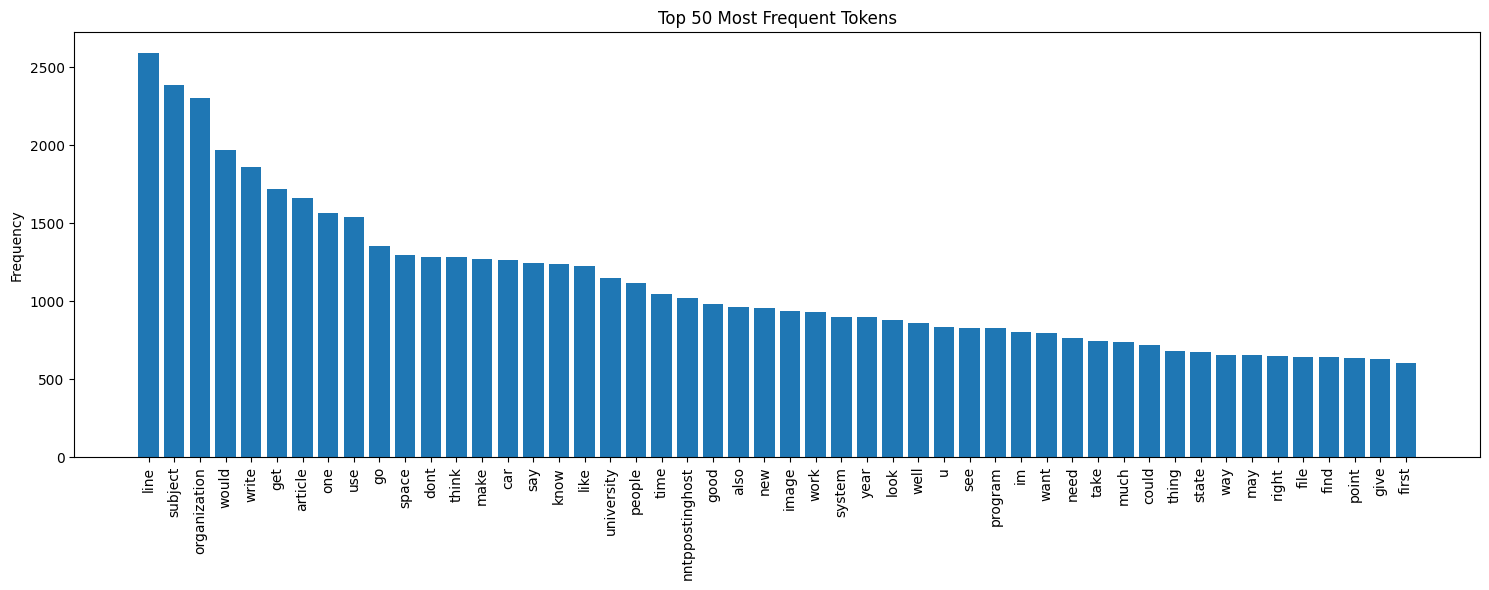

In [68]:
# Visualize top tokens
top_tokens = counter.most_common(50)

tokens, counts = zip(*top_tokens)

          
plt.figure(figsize=(15, 6))
plt.bar(tokens, counts)
plt.xticks(rotation=90)
plt.title("Top 50 Most Frequent Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
        

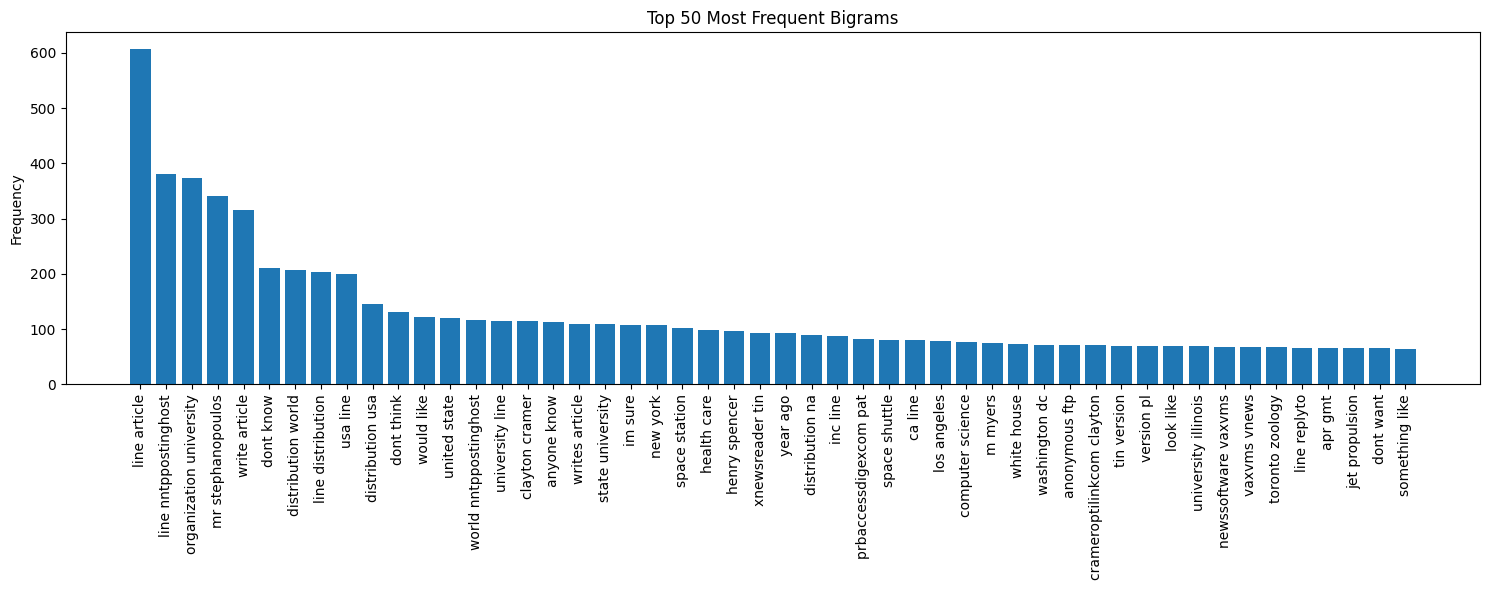

In [69]:
# visualize top 50 bigrams
top_bigrams = bigram_counts.most_common(50)

# Join tokens in bigrams to make them readable on the plot
bigram_labels = [' '.join(bigram) for bigram, _ in top_bigrams]
counts = [count for _, count in top_bigrams]

# Plot
plt.figure(figsize=(15, 6))
plt.bar(bigram_labels, counts)
plt.xticks(rotation=90)
plt.title("Top 50 Most Frequent Bigrams")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [70]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])


#Bag of words
count_vectorizer = CountVectorizer(preprocessor=preprocess_text, max_features=50)
X_train_counts = count_vectorizer.fit_transform(X_train.tolist())



#TF-IDF
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text, max_features=50)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.tolist())

In [71]:
# Confirm the split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nClass distribution in training set:\n{y_train.value_counts()}")
print(f"\nClass distribution in testing set:\n{y_test.value_counts()}")

# Examine the vocabulary size for each vectorizer (should be 50)
count_vocab_size = len(count_vectorizer.get_feature_names_out())
tfidf_vocab_size = len(tfidf_vectorizer.get_feature_names_out())

# Show the first few feature names
print(f"\nSample of feature names: {count_vectorizer.get_feature_names_out()[:3]}")
print(f"\nSample of feature names: {tfidf_vectorizer.get_feature_names_out()[:3]}")

Training set size: 1788
Testing set size: 448

Class distribution in training set:
category
rec.autos             475
sci.space             474
comp.graphics         467
talk.politics.misc    372
Name: count, dtype: int64

Class distribution in testing set:
category
sci.space             119
rec.autos             119
comp.graphics         117
talk.politics.misc     93
Name: count, dtype: int64
TF-IDF vocabulary size: 50

Bag of Words feature matrix shape: (1788, 50)
TF-IDF feature matrix shape: (1788, 50)

Sample of feature names: ['also' 'article' 'car']

Sample of feature names: ['also' 'article' 'car']


In [72]:
# Multinomial Naive Bayes for bag of words
nb_bow = MultinomialNB()
nb_bow.fit(X_train_counts, y_train)

# Multinomial Naive Bayes for TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)


# Function to display the most informative features for each class
def display_top_features(classifier, vectorizer, class_labels, n=5):
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    top_features = {}
    
    # For each class, find the features with highest log probability
    for i, label in enumerate(class_labels):
        # Sort indices by feature log probability
        top_indices = np.argsort(classifier.feature_log_prob_[i])[-n:][::-1]
        
        # Get the feature names
        top_features[label] = [feature_names[j] for j in top_indices]
        
        # Print the top features
        print(f"\nTop {n} features for class '{label}':")
        for rank, feature in enumerate(top_features[label], 1):
            print(f"{rank}. {feature}")
    
    return top_features

In [73]:
# Display top features for the Bag of Words model
print("Top features from Bag of Words model:")
bow_top_features = display_top_features(nb_bow, count_vectorizer, nb_bow.classes_)

# Display top features for the TF-IDF model
print("\nTop features from TF-IDF model:")
tfidf_top_features = display_top_features(nb_tfidf, tfidf_vectorizer, nb_tfidf.classes_)


Top features from Bag of Words model:

Top 5 features for class 'comp.graphics':
1. image
2. line
3. subject
4. organization
5. file

Top 5 features for class 'rec.autos':
1. car
2. line
3. subject
4. organization
5. get

Top 5 features for class 'sci.space':
1. space
2. line
3. subject
4. organization
5. would

Top 5 features for class 'talk.politics.misc':
1. would
2. people
3. say
4. make
5. go

Top features from TF-IDF model:

Top 5 features for class 'comp.graphics':
1. line
2. file
3. subject
4. organization
5. university

Top 5 features for class 'rec.autos':
1. car
2. get
3. line
4. subject
5. organization

Top 5 features for class 'sci.space':
1. space
2. would
3. line
4. subject
5. write

Top 5 features for class 'talk.politics.misc':
1. people
2. article
3. write
4. would
5. say


In [74]:
#transform test
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#make predictions
y_pred_bow = nb_bow.predict(X_test_counts)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

#Evaluate model
def evaluate_model(y_true, y_pred, model_name):

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print evaluation results
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate and print classification report
    report = classification_report(y_true, y_pred)
    print(f"\nClassification Report:\n{report}")
    
    # Return the accuracy
    return accuracy

Evaluation for Bag of Words + Naive Bayes:
Accuracy: 0.6987

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.70      0.70      0.70       117
         rec.autos       0.61      0.86      0.72       119
         sci.space       0.79      0.61      0.69       119
talk.politics.misc       0.77      0.60      0.67        93

          accuracy                           0.70       448
         macro avg       0.72      0.69      0.70       448
      weighted avg       0.72      0.70      0.70       448

Evaluation for TF-IDF + Naive Bayes:
Accuracy: 0.7299

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.70      0.79      0.74       117
         rec.autos       0.77      0.83      0.80       119
         sci.space       0.69      0.71      0.70       119
talk.politics.misc       0.78      0.55      0.65        93

          accuracy                           0.73    

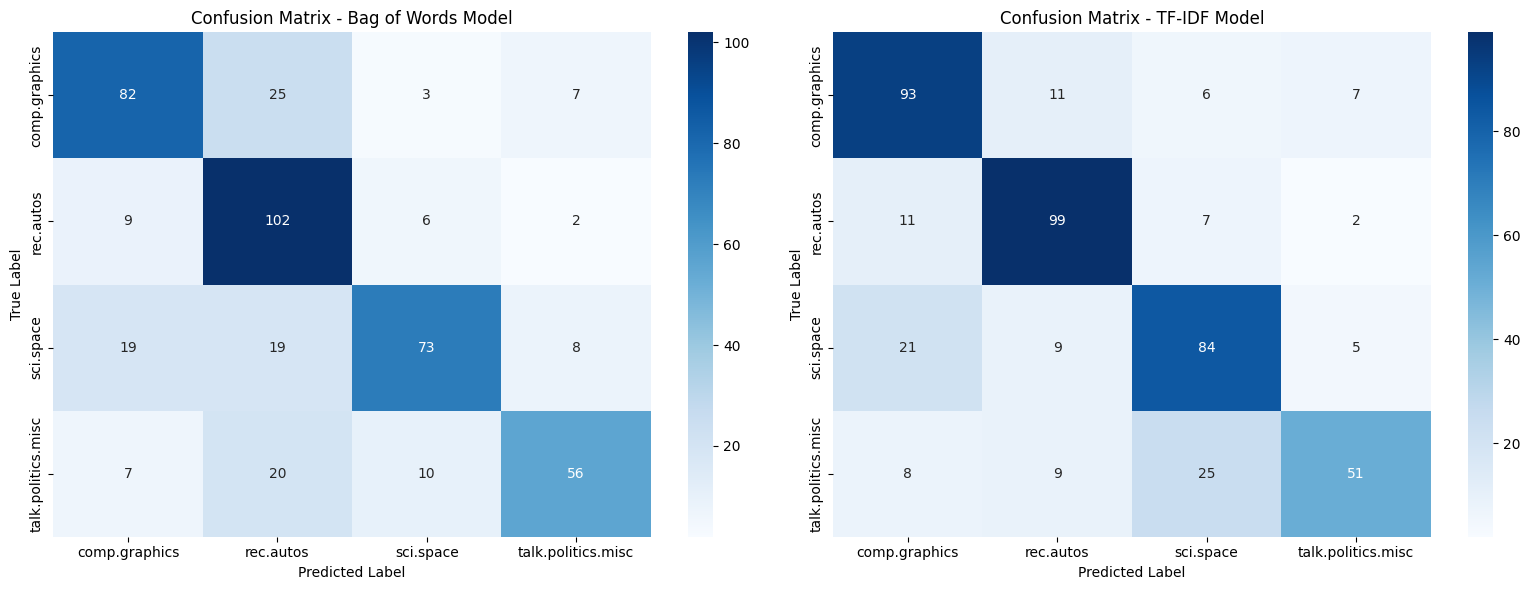

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


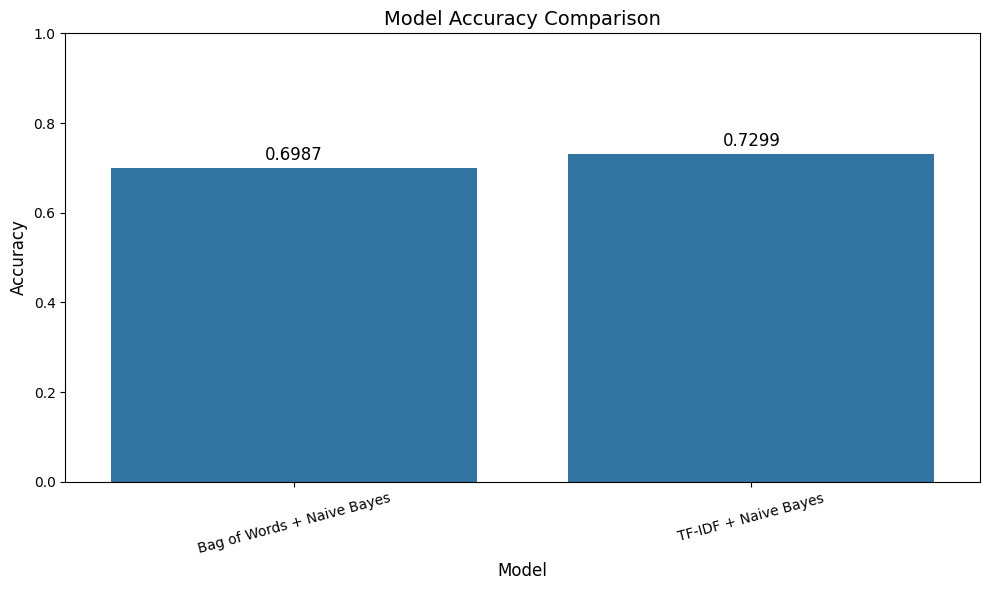

In [75]:
#Accuracy
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words + Naive Bayes")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF + Naive Bayes")

#Plot CM
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix for Bag of Words model
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=nb_bow.classes_, 
            yticklabels=nb_bow.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix - Bag of Words Model', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Confusion matrix for TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=nb_tfidf.classes_, 
            yticklabels=nb_tfidf.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix - TF-IDF Model', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.show()

# Compare model accuracies
models = ['Bag of Words + Naive Bayes', 'TF-IDF + Naive Bayes']
accuracies = [bow_accuracy, tfidf_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=15)

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [76]:
text_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess_text)),
    ('classifier', MultinomialNB())
])

# Define distributions instead of full grids
param_distributions = {
    'vectorizer__max_features': [50, 100, 200],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.85, 0.9, 0.95],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': [0.1, 0.5, 1.0]  # draws values between 0.1 and 1.1
}

# Initialize randomized search
random_search = RandomizedSearchCV(
    text_pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # number of sampled parameter sets
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
)

# Fit to training data
random_search.fit(X_train, y_train)

# Evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best parameters: {random_search.best_params_}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 3, 'vectorizer__max_features': 200, 'vectorizer__max_df': 0.85, 'classifier__alpha': 0.1}


In [77]:
"""
Grid search was taking too long so I went with a Random Search which still takes a good chunk of time

text_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess_text)),
    ('classifier', MultinomialNB())
])

param_grid = {    
    'vectorizer__max_features': [50, 100],
    'vectorizer__min_df': [1, 2],
    'vectorizer__max_df': [0.85, 0.9, 0.95],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': [0.5, 1.0]
}


grid_search = GridSearchCV(text_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)
"""

"\nGrid search was taking too long so I went with a Random Search which still takes a good chunk of time\n\ntext_pipeline = Pipeline([\n    ('vectorizer', TfidfVectorizer(preprocessor=preprocess_text)),\n    ('classifier', MultinomialNB())\n])\n\nparam_grid = {    \n    'vectorizer__max_features': [50, 100],\n    'vectorizer__min_df': [1, 2],\n    'vectorizer__max_df': [0.85, 0.9, 0.95],\n    'vectorizer__ngram_range': [(1, 1), (1, 2)],\n    'classifier__alpha': [0.5, 1.0]\n}\n\n\ngrid_search = GridSearchCV(text_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)\ngrid_search.fit(X_train, y_train)\n\n\nbest_model = grid_search.best_estimator_\ny_pred_grid = best_model.predict(X_test)\n"

In [78]:
#Print best parameters
print("Best Parameters:")
print(random_search.best_params_)
print(f"\nBest Cross-Validation Score: {random_search.best_score_:.4f}")

Best Parameters:
{'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 3, 'vectorizer__max_features': 200, 'vectorizer__max_df': 0.85, 'classifier__alpha': 0.1}

Best Cross-Validation Score: 0.8479


Evaluation for Improved TF-IDF + Naive Bayes:
Accuracy: 0.8661

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.84      0.85      0.84       117
         rec.autos       0.82      0.92      0.87       119
         sci.space       0.88      0.82      0.85       119
talk.politics.misc       0.95      0.88      0.92        93

          accuracy                           0.87       448
         macro avg       0.87      0.87      0.87       448
      weighted avg       0.87      0.87      0.87       448



Evaluation for Improved TF-IDF + Naive Bayes:
Accuracy: 0.8661

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.84      0.85      0.84       117
         rec.autos       0.82      0.92      0.87       119
         sci.space       0.88      0.82      0.85       119
talk.politics.misc       0.95      0.88      0.92        93

          accuracy                           0.87       448
         macro avg       0.87      0.87      0.87       448
      weighted avg       0.87      0.87      0.87       448



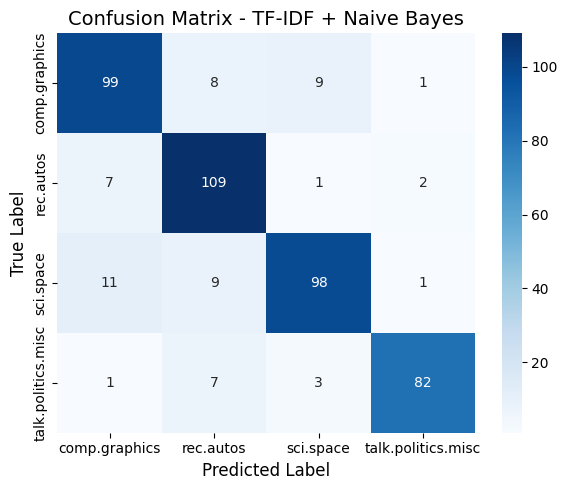

In [80]:
#New improved states
improved_tfidf_accuracy = evaluate_model(y_test, y_pred, "Improved TF-IDF + Naive Bayes")

# Confusion matrix for improved model
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix - TF-IDF + Naive Bayes', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()




In [81]:
#Function for predicting categories
def classify_feedback(feedback_text):
    # Predict the category
    category = best_model.predict([feedback_text])[0]
    
    # Get prediction probabilities
    probabilities = best_model.predict_proba([feedback_text])[0]
    
    # Find the confidence (probability of the predicted class)
    confidence = np.max(probabilities)
    
    # Create and return the result dictionary
    result = {
        'feedback_text': feedback_text,
        'category': category,
        'confidence': confidence,
        'all_probabilities': dict(zip(best_model.classes_, probabilities))
    }
    
    return result

In [82]:
#Test prediction function
new_feedback = [
    "People are voting according to this article",
    "My car needs an inspection done...where do I go?",
    "Mars is far away, but not as far as Jupiter",
    "The best camera available can be a DSLR 5000", 
    "This is misellaneous just to see what results might come about."]

for feedback in new_feedback:
    result = classify_feedback(feedback)
    
    print(f'\nFeedback: {result["feedback_text"]}')
    print(f'Predicted Category: {result["category"]}')
    print(f'Confidence: {result["confidence"]:.4f}')
    
    # Show all class probabilities
    print('All department probabilities:')
    for dept, prob in result['all_probabilities'].items():
        print(f'  {dept}: {prob:.4f}')


Feedback: People are voting according to this article
Predicted Category: talk.politics.misc
Confidence: 0.5063
All department probabilities:
  comp.graphics: 0.0608
  rec.autos: 0.2360
  sci.space: 0.1969
  talk.politics.misc: 0.5063

Feedback: My car needs an inspection done...where do I go?
Predicted Category: rec.autos
Confidence: 0.8726
All department probabilities:
  comp.graphics: 0.0457
  rec.autos: 0.8726
  sci.space: 0.0353
  talk.politics.misc: 0.0464

Feedback: Mars is far away, but not as far as Jupiter
Predicted Category: sci.space
Confidence: 0.3142
All department probabilities:
  comp.graphics: 0.2548
  rec.autos: 0.2008
  sci.space: 0.3142
  talk.politics.misc: 0.2301

Feedback: The best camera available can be a DSLR 5000
Predicted Category: comp.graphics
Confidence: 0.5440
All department probabilities:
  comp.graphics: 0.5440
  rec.autos: 0.1431
  sci.space: 0.2607
  talk.politics.misc: 0.0522

Feedback: This is misellaneous just to see what results might come about